# STA130 Final Course Project
## Oscar Heath

We'll start by importing the data set, and adding columns of the error rate of the different models.

In [1]:
import pandas as pd
import numpy as np
import scipy
import plotly.express as px
from sklearn.metrics import ConfusionMatrixDisplay
df_indicators = pd.read_csv('country_indicators.csv')
df_preds = pd.read_csv('test_predictions.csv')


df_preds['error_transformer'] = np.abs(df_preds['y_true_transformer'].astype(float) - df_preds['y_pred_proba_transformer'])

df_preds['error_xgboost'] = np.abs(df_preds['y_true_xgboost'].astype(float) - df_preds['y_pred_proba_xgboost'])

df_preds['error_ffnn'] = np.abs(df_preds['y_true_ffnn'].astype(float) - df_preds['y_pred_proba_ffnn'])

This function creates indicator variables ('one hot' variables) as columns of our dataset in order for us to add some categorical variables to our model.

In [2]:
import itertools

# Indicator variables are often called "one hot" encodings
def one_hot(df, cols):
    """ One-hot encode given `cols` and add as new columns
        to `df`
        
        Returns tuple of `df` with new columns and list of
        new column names.
    """
    new_cols = list()
    new_col_names = list()
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each)
        new_cols.append(dummies)
        new_col_names.append(dummies.columns.values)

    df = pd.concat([df]+new_cols, axis=1)
    new_col_names = list(itertools.chain.from_iterable(new_col_names))
    return df, new_col_names

## Here we'll make an initial list of potentially useful columns for our model. We started with this whole list of variables, and then used backwards selection to eliminate the variables that caused massive colinearity. (We left in a few to show the process)

In [3]:
continuous_columns = [#'hdr_hdi_rank_2021',
                       #'fsi_total',
                      #'fsi_p3:_human_rights',
                      'hdr_coef_ineq_2021',
                        'hdr_hdi_m_2021',
                      'sowc_women-s-economic-empowerment__labour-force-participation-rate-2010-2020-r_male_total',
                      'sowc_women-s-economic-empowerment__labour-force-participation-rate-2010-2020-r_female_total',
                      'sowc_demographics__population-thousands-2021_under-5',
                      'sowc_demographics__annual-population-growth-rate_2000-2020',
                      'sowc_demographics__dependency-ratio-2021_old-age-dependency-ratio_2021-0',
                      'sowc_early-childhood-development__attendance-in-early-childhood-education-2013-2021-r_total',
                     #'sowc_maternal-and-newborn-health__delivery-care-2016-2021-r_c-section',
                     #'sowc_maternal-and-newborn-health__maternal-mortality-2020-c_lifetime-risk-of-maternal-death-1-in-x',
                     'sowc_demographics__life-expectancy-at-birth-years_2000-0',
                     #'fsi_p1:_state_legitimacy',
                     #'fsi_e3:_human_flight_and_brain_drain',
                     #'fsi_s2:_refugees_and_idps',
                     #'fsi_c1:_security_apparatus',
                     #'fsi_s1:_demographic_pressures',
                     #'sowc_demographics__annual-population-growth-rate_2020-2030-a',
                     #'hdr_gni_pc_f_2019',
                     #'sowc_migration__international-migrant-stock-2020_total-thousands',
                     #'sowc_migration__new-internal-displacements-2021_total-t',
                     #'sowc_wash__healthcare-facilities-2021_basic-hygiene-services_secondary'
]


## Next, we merged df_indicators and df_preds together into one big dataset in order to more easily work with them, and added indicator variables for the 4 different fsi categories: 'Alert', 'Stable', 'Sustainable' and 'Warning.'

In [4]:
df = df_preds.merge(df_indicators, left_on='iso3', right_on='iso3', how='inner')
df['fsi_rank'] = df['fsi_rank'].astype('string').str.replace(r'\D', '', regex=True).replace('', pd.NA)
df = one_hot(df, ['fsi_category'])[0]


categorical_variables = ['fsi_category_Alert', 
                         'fsi_category_Stable', 
                         'fsi_category_Sustainable', 
                         'fsi_category_Warning'] 
df

yearmonth fips  y_pred_transformer  y_pred_proba_transformer  \
0       202211   FJ               False                  0.183897   
1       202212   FJ               False                  0.267831   
2       202211   TZ               False                  0.482585   
3       202212   TZ               False                  0.187792   
4       202301   TZ                True                  0.539319   
..         ...  ...                 ...                       ...   
359     202211   MJ               False                  0.182196   
360     202212   MJ               False                  0.203236   
361     202211   TD                True                  0.527107   
362     202212   TD                True                  0.555677   
363     202301   TD                True                  0.565700   

     y_true_transformer  y_pred_xgboost  y_pred_proba_xgboost  y_true_xgboost  \
0                 False           False              0.066500           False   
1                 False           False              0.099643           False   
2                 False            True              0.704086            True   
3                 False            True              0.638444            True   
4                  True            True              0.608380           False   
..                  ...             ...                   ...             ...   
359               False           False              0.079453           False   
360               False           False              0.060189           False   
361               False            True              0.697625            True   
362               False            True              0.729246           False   
363                True            True              0.591722           False   

     y_pred_ffnn  y_pred_proba_ffnn  ...  fsi_p2:_public_services  \
0          False           0.409958  ...                      4.2   
1          False           0.406696  ...                      4.2   
2           True           0.545236  ...                      8.4   
3           True           0.534560  ...                      8.4   
4           True           0.538583  ...                      8.4   
..           ...                ...  ...                      ...   
359        False           0.291874  ...                      3.8   
360        False           0.300321  ...                      3.8   
361        False           0.335496  ...                      4.3   
362        False           0.324000  ...                      4.3   
363        False           0.332455  ...                      4.3   

    fsi_p3:_human_rights  fsi_c1:_security_apparatus  \
0                    5.4                         6.4   
1                    5.4                         6.4   
2                    5.6                         4.6   
3                    5.6                         4.6   
4                    5.6                         4.6   
..                   ...                         ...   
359                  2.9                         4.0   
360                  2.9                         4.0   
361                  3.5                         7.3   
362                  3.5                         7.3   
363                  3.5                         7.3   

     fsi_c2:_factionalized_elites  fsi_x1:_external_intervention  \
0                             8.2                            6.6   
1                             8.2                            6.6   
2                             6.5                            6.0   
3                             6.5                            6.0   
4                             6.5                            6.0   
..                            ...                            ...   
359                           6.5                            6.3   
360                           6.5                            6.3   
361                           5.6                            3.3   
362                  

## We then created a correlation matrix in order to observe correlation between the variables

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
# CODE FROM EVAN WHEELER AND SCOTT SCHWARTZ
def corr_heatmap(df):
    # plot correlation heatmap based on code from:
    # https://medium.com/@nikolh92/helpful-visualisations-for-linear-regression-646a5648ad9d
    sns.set(style="white")
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=bool)
    #mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(20, 16))
    
    cmap = sns.diverging_palette(10, 220, as_cmap=True)
    return sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, square=True,
                       linewidths=.5, annot=False, cbar_kws={"shrink": .5})

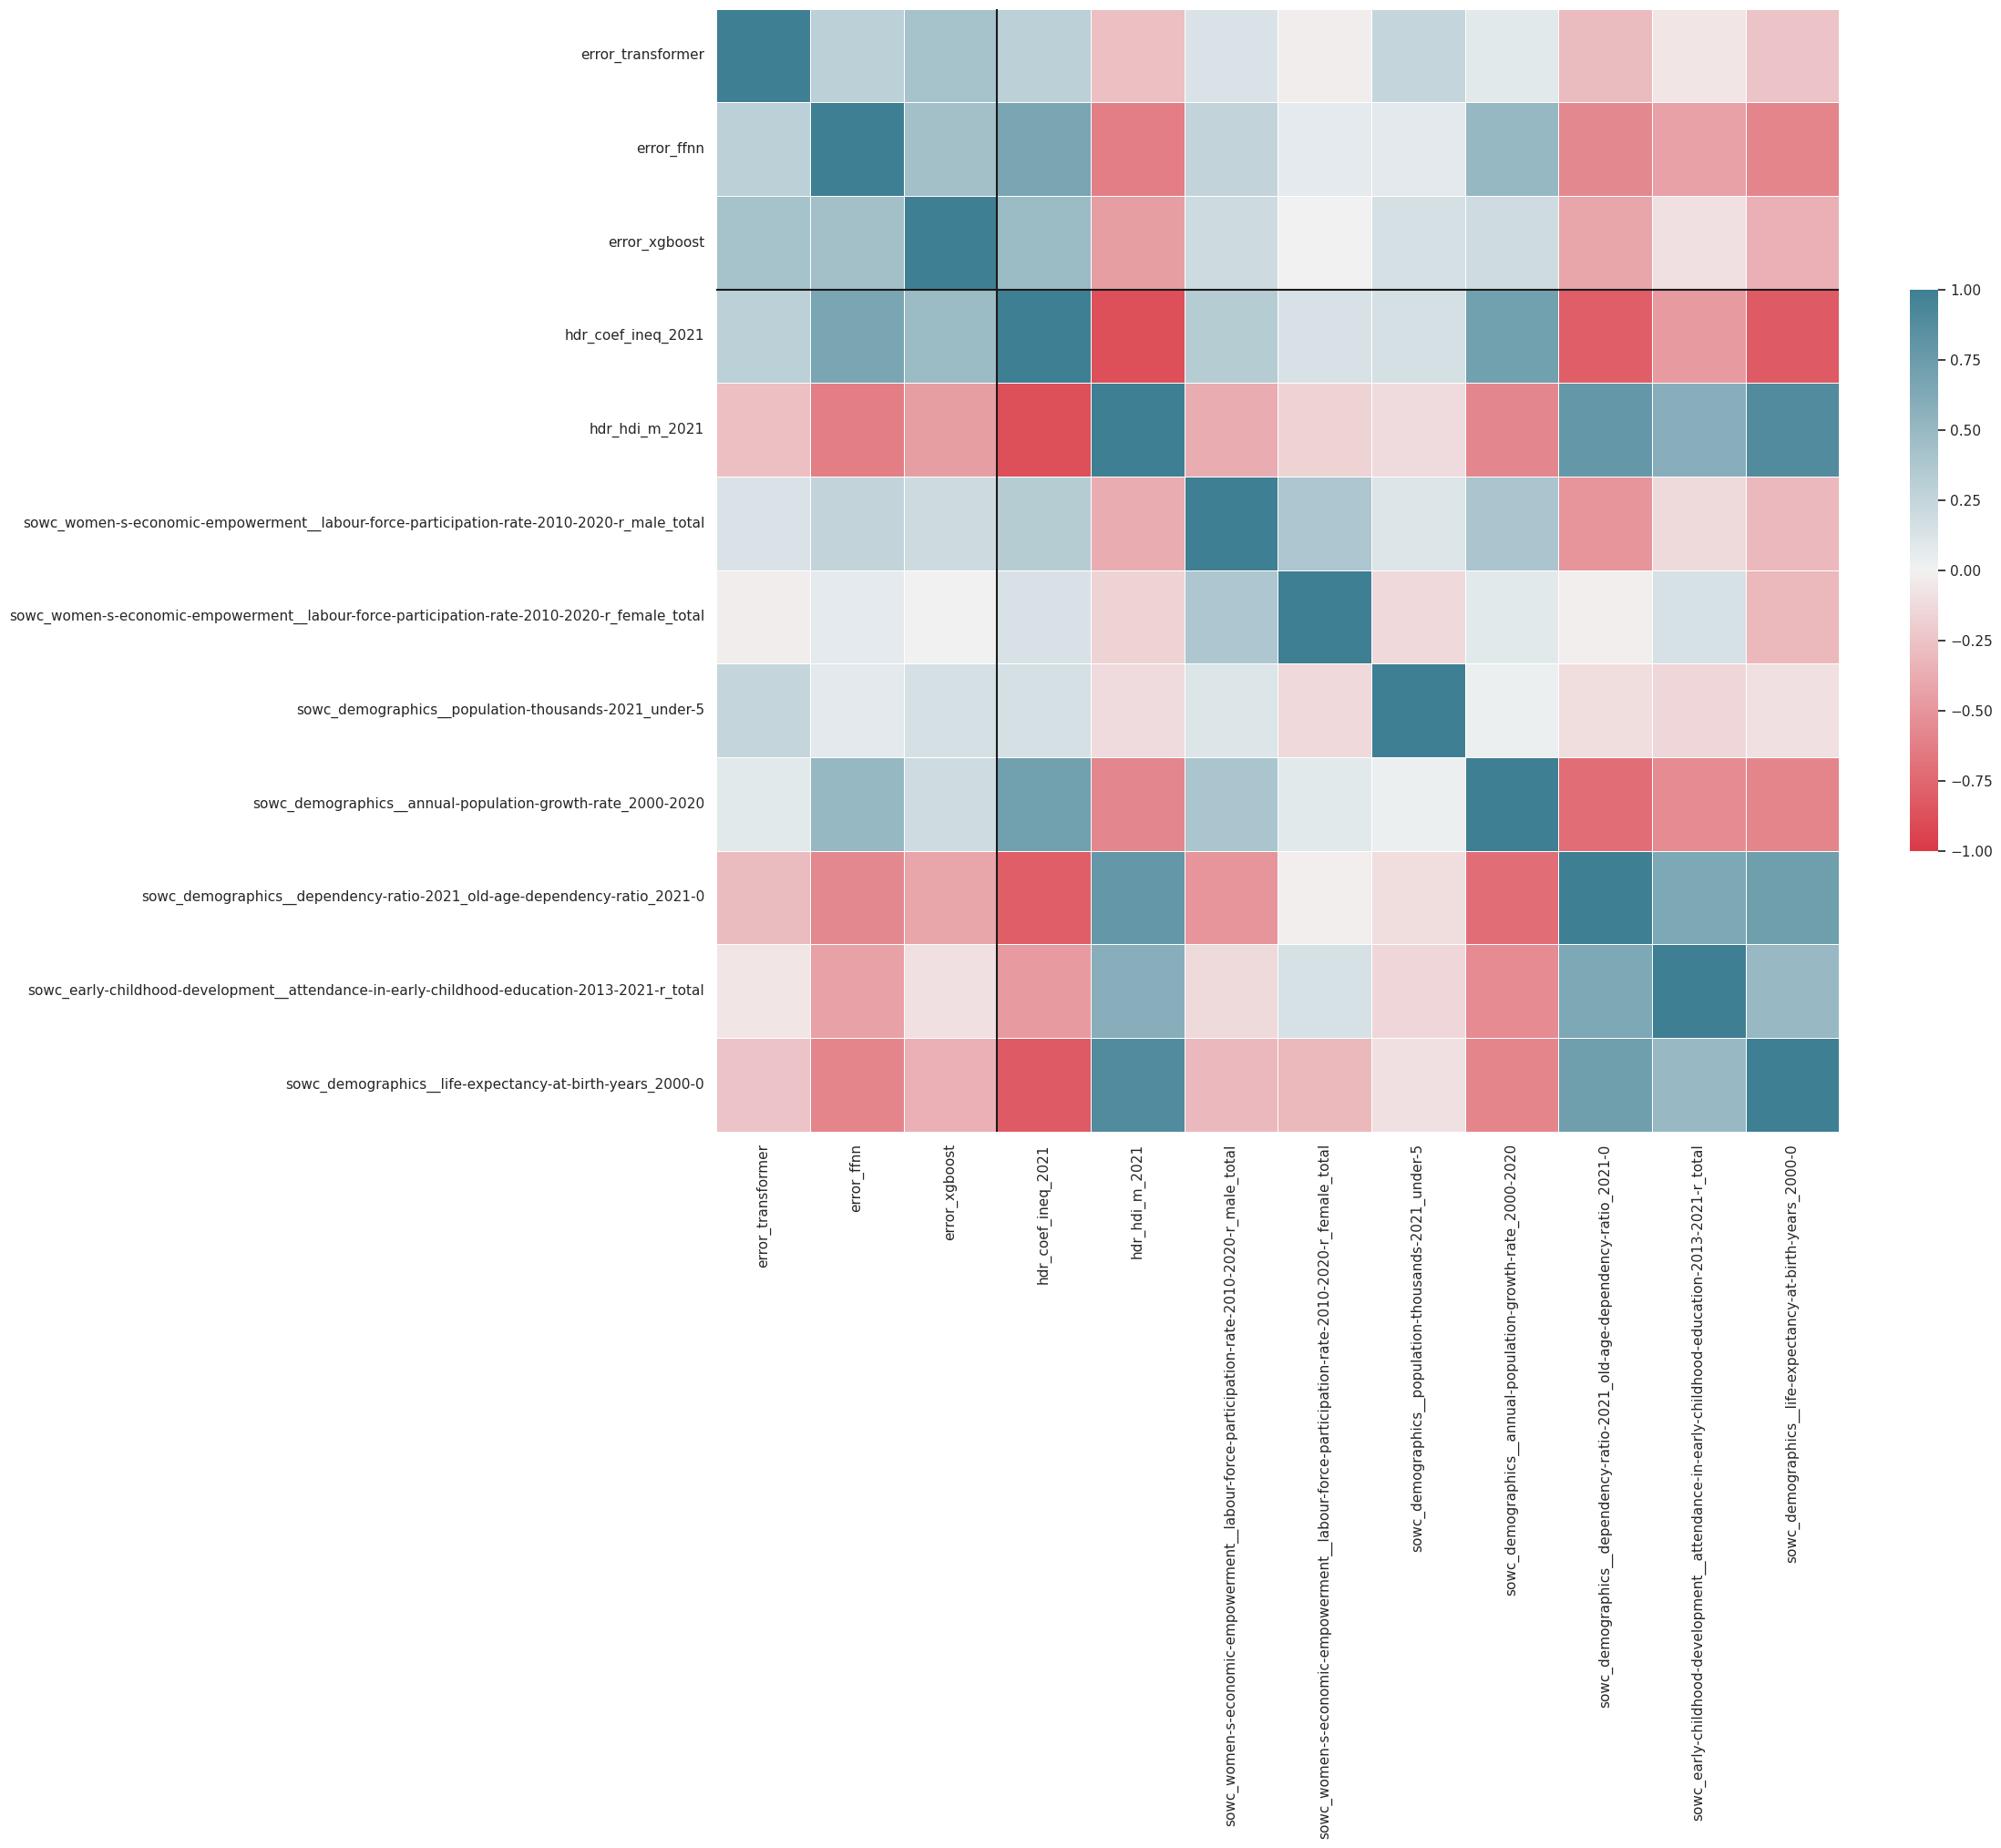

In [6]:
corr_heatmap(df[['error_transformer','error_ffnn', 'error_xgboost'] + continuous_columns])
_ = plt.axhline(y=3, c='k'); plt.axvline(x=3, c='k')

## There seems to be a few columns that have correlations with other columns, but we'll deal with them later...

## Now, we standardize our continuous variables, and eliminate any unnecessary columns from our database (any columns we aren't studying). We also add a new temporary one-hot variable indicating which predictions the models made for each country.

In [7]:
np.random.seed(1)
import statsmodels.api as sm

df[continuous_columns] = (df[continuous_columns] - df[continuous_columns].mean())/df[continuous_columns].std()

df = df[['error_transformer','error_ffnn', 'error_xgboost', 'y_pred_transformer', 'y_pred_ffnn', 'y_pred_xgboost' ] + continuous_columns + categorical_variables]


df['model_transformer'] = df['error_transformer'].astype(str)*0+"transformer"
df['model_ffnn'] = df['error_ffnn'].astype(str)*0+"ffnn"
df['model_xgboost'] = df['error_xgboost'].astype(str)*0+"xgboost"


df['prediction_transformer'] = df.y_pred_transformer.astype(int)
df['prediction_ffnn'] = df.y_pred_ffnn.astype(int)
df['prediction_xgboost'] = df.y_pred_xgboost.astype(int)


df = df.dropna()
df

/tmp/ipykernel_63/719757629.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['model_transformer'] = df['error_transformer'].astype(str)*0+"transformer"
/tmp/ipykernel_63/719757629.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['model_ffnn'] = df['error_ffnn'].astype(str)*0+"ffnn"
/tmp/ipykernel_63/719757629.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

error_transformer  error_ffnn  error_xgboost  y_pred_transformer  \
10            0.708086    0.349594       0.692945                True   
11            0.183901    0.356072       0.662224               False   
12            0.539889    0.347548       0.665177                True   
16            0.461546    0.398537       0.480096               False   
17            0.346367    0.395459       0.410326               False   
..                 ...         ...            ...                 ...   
356           0.184977    0.291478       0.241428               False   
357           0.201217    0.278109       0.189688               False   
358           0.202107    0.278429       0.236479               False   
359           0.182196    0.291874       0.079453               False   
360           0.203236    0.300321       0.060189               False   

     y_pred_ffnn  y_pred_xgboost  hdr_coef_ineq_2021  hdr_hdi_m_2021  \
10         False            True           -1.169841        0.554816   
11         False            True           -1.169841        0.554816   
12         False            True           -1.169841        0.554816   
16         False           False           -0.119990       -0.061256   
17         False            True           -0.119990       -0.061256   
..           ...             ...                 ...             ...   
356        False           False           -0.852211        0.539857   
357        False           False           -0.852211        0.539857   
358        False           False           -0.852211        0.539857   
359        False           False           -0.949603        0.759869   
360        False           False           -0.949603        0.759869   

     sowc_women-s-economic-empowerment__labour-force-participation-rate-2010-2020-r_male_total  \
10                                            0.348718                                           
11                                            0.348718                                           
12                                            0.348718                                           
16                                            1.140701                                           
17                                            1.140701                                           
..                                                 ...                                           
356                                          -1.163249                                           
357                                          -1.163249                                           
358                                          -1.163249                                           
359                                          -1.091251                                           
360                                          -1.091251                                           

     sowc_women-s-economic-empowerment__labour-force-participation-rate-2010-2020-r_female_total  \
10                                            0.668604                                             
11                                            0.668604                                             
12                                            0.668604                                             
16                                            0.098811                                             
17                                            0.098811                                             
..                                                 ...                                             
356                                          -0.278916                                             
357                                          -0.278916                                             
358                                          -0.278916                                             
359                                          -0.285319                                

## All that's left to do for our design matrix to be done is to stack all the predictions together, and adding a indicator variables indicating whether the prediction was 1 or 0, as well as creating new variables modelling the continuous variable x our indicator variables of the model (ex: 'sowc_demographics__life-expectancy-at-birth-years_2000-0 X xgboost').

In [8]:
design_matrix = \
pd.concat([df[['error_transformer', 'model_transformer', 'prediction_transformer']+continuous_columns + categorical_variables].rename(columns={'error_transformer':'error','model_transformer':'model','prediction_transformer':'predicts1'}),
           df[['error_ffnn', 'model_ffnn', 'prediction_ffnn']+continuous_columns + categorical_variables].rename(columns={'error_ffnn':'error','model_ffnn':'model','prediction_ffnn':'predicts1'}),
           df[['error_xgboost', 'model_xgboost', 'prediction_xgboost']+continuous_columns + categorical_variables].rename(columns={'error_xgboost':'error','model_xgboost':'model','prediction_xgboost':'predicts1'})],
          ignore_index=True)

for x in continuous_columns:
    design_matrix[x+' X predicts1'] = design_matrix[x]*design_matrix['predicts1']

design_matrix['transformer'] = (design_matrix['model']=="transformer").astype(int)
design_matrix['xgboost'] = (design_matrix['model']=="xgboost").astype(int)
design_matrix['ffnn'] = (design_matrix['model']=="ffnn").astype(int)

for x in continuous_columns:
    design_matrix[x+' X transformer'] = design_matrix[x]*design_matrix['transformer']
    design_matrix[x+' X xgboost'] = design_matrix[x]*design_matrix['xgboost']
    design_matrix[x+' X ffnn'] = design_matrix[x]*design_matrix['ffnn']

del design_matrix['model']

design_matrix

error  predicts1  hdr_coef_ineq_2021  hdr_hdi_m_2021  \
0    0.708086          1           -1.169841        0.554816   
1    0.183901          0           -1.169841        0.554816   
2    0.539889          1           -1.169841        0.554816   
3    0.461546          0           -0.119990       -0.061256   
4    0.346367          0           -0.119990       -0.061256   
..        ...        ...                 ...             ...   
577  0.241428          0           -0.852211        0.539857   
578  0.189688          0           -0.852211        0.539857   
579  0.236479          0           -0.852211        0.539857   
580  0.079453          0           -0.949603        0.759869   
581  0.060189          0           -0.949603        0.759869   

     sowc_women-s-economic-empowerment__labour-force-participation-rate-2010-2020-r_male_total  \
0                                             0.348718                                           
1                                             0.348718                                           
2                                             0.348718                                           
3                                             1.140701                                           
4                                             1.140701                                           
..                                                 ...                                           
577                                          -1.163249                                           
578                                          -1.163249                                           
579                                          -1.163249                                           
580                                          -1.091251                                           
581                                          -1.091251                                           

     sowc_women-s-economic-empowerment__labour-force-participation-rate-2010-2020-r_female_total  \
0                                             0.668604                                             
1                                             0.668604                                             
2                                             0.668604                                             
3                                             0.098811                                             
4                                             0.098811                                             
..                                                 ...                                             
577                                          -0.278916                                             
578                                          -0.278916                                             
579                                          -0.278916                                             
580                                          -0.285319                                             
581                                          -0.285319                                             

     sowc_demographics__population-thousands-2021_under-5  \
0                                            -0.215434      
1                                            -0.215434      
2                                            -0.215434      
3                                             1.335775      
4                                             1.335775      
..                                                 ...      
577                                          -0.341889      
578                                          -0.341889      
579                                          -0.341889      
580                                          -0.365332      
581                                          -0.365332      

     sowc_demographics__annual-population-growth-rate_2000-2020  \
0                                            -0.398971       

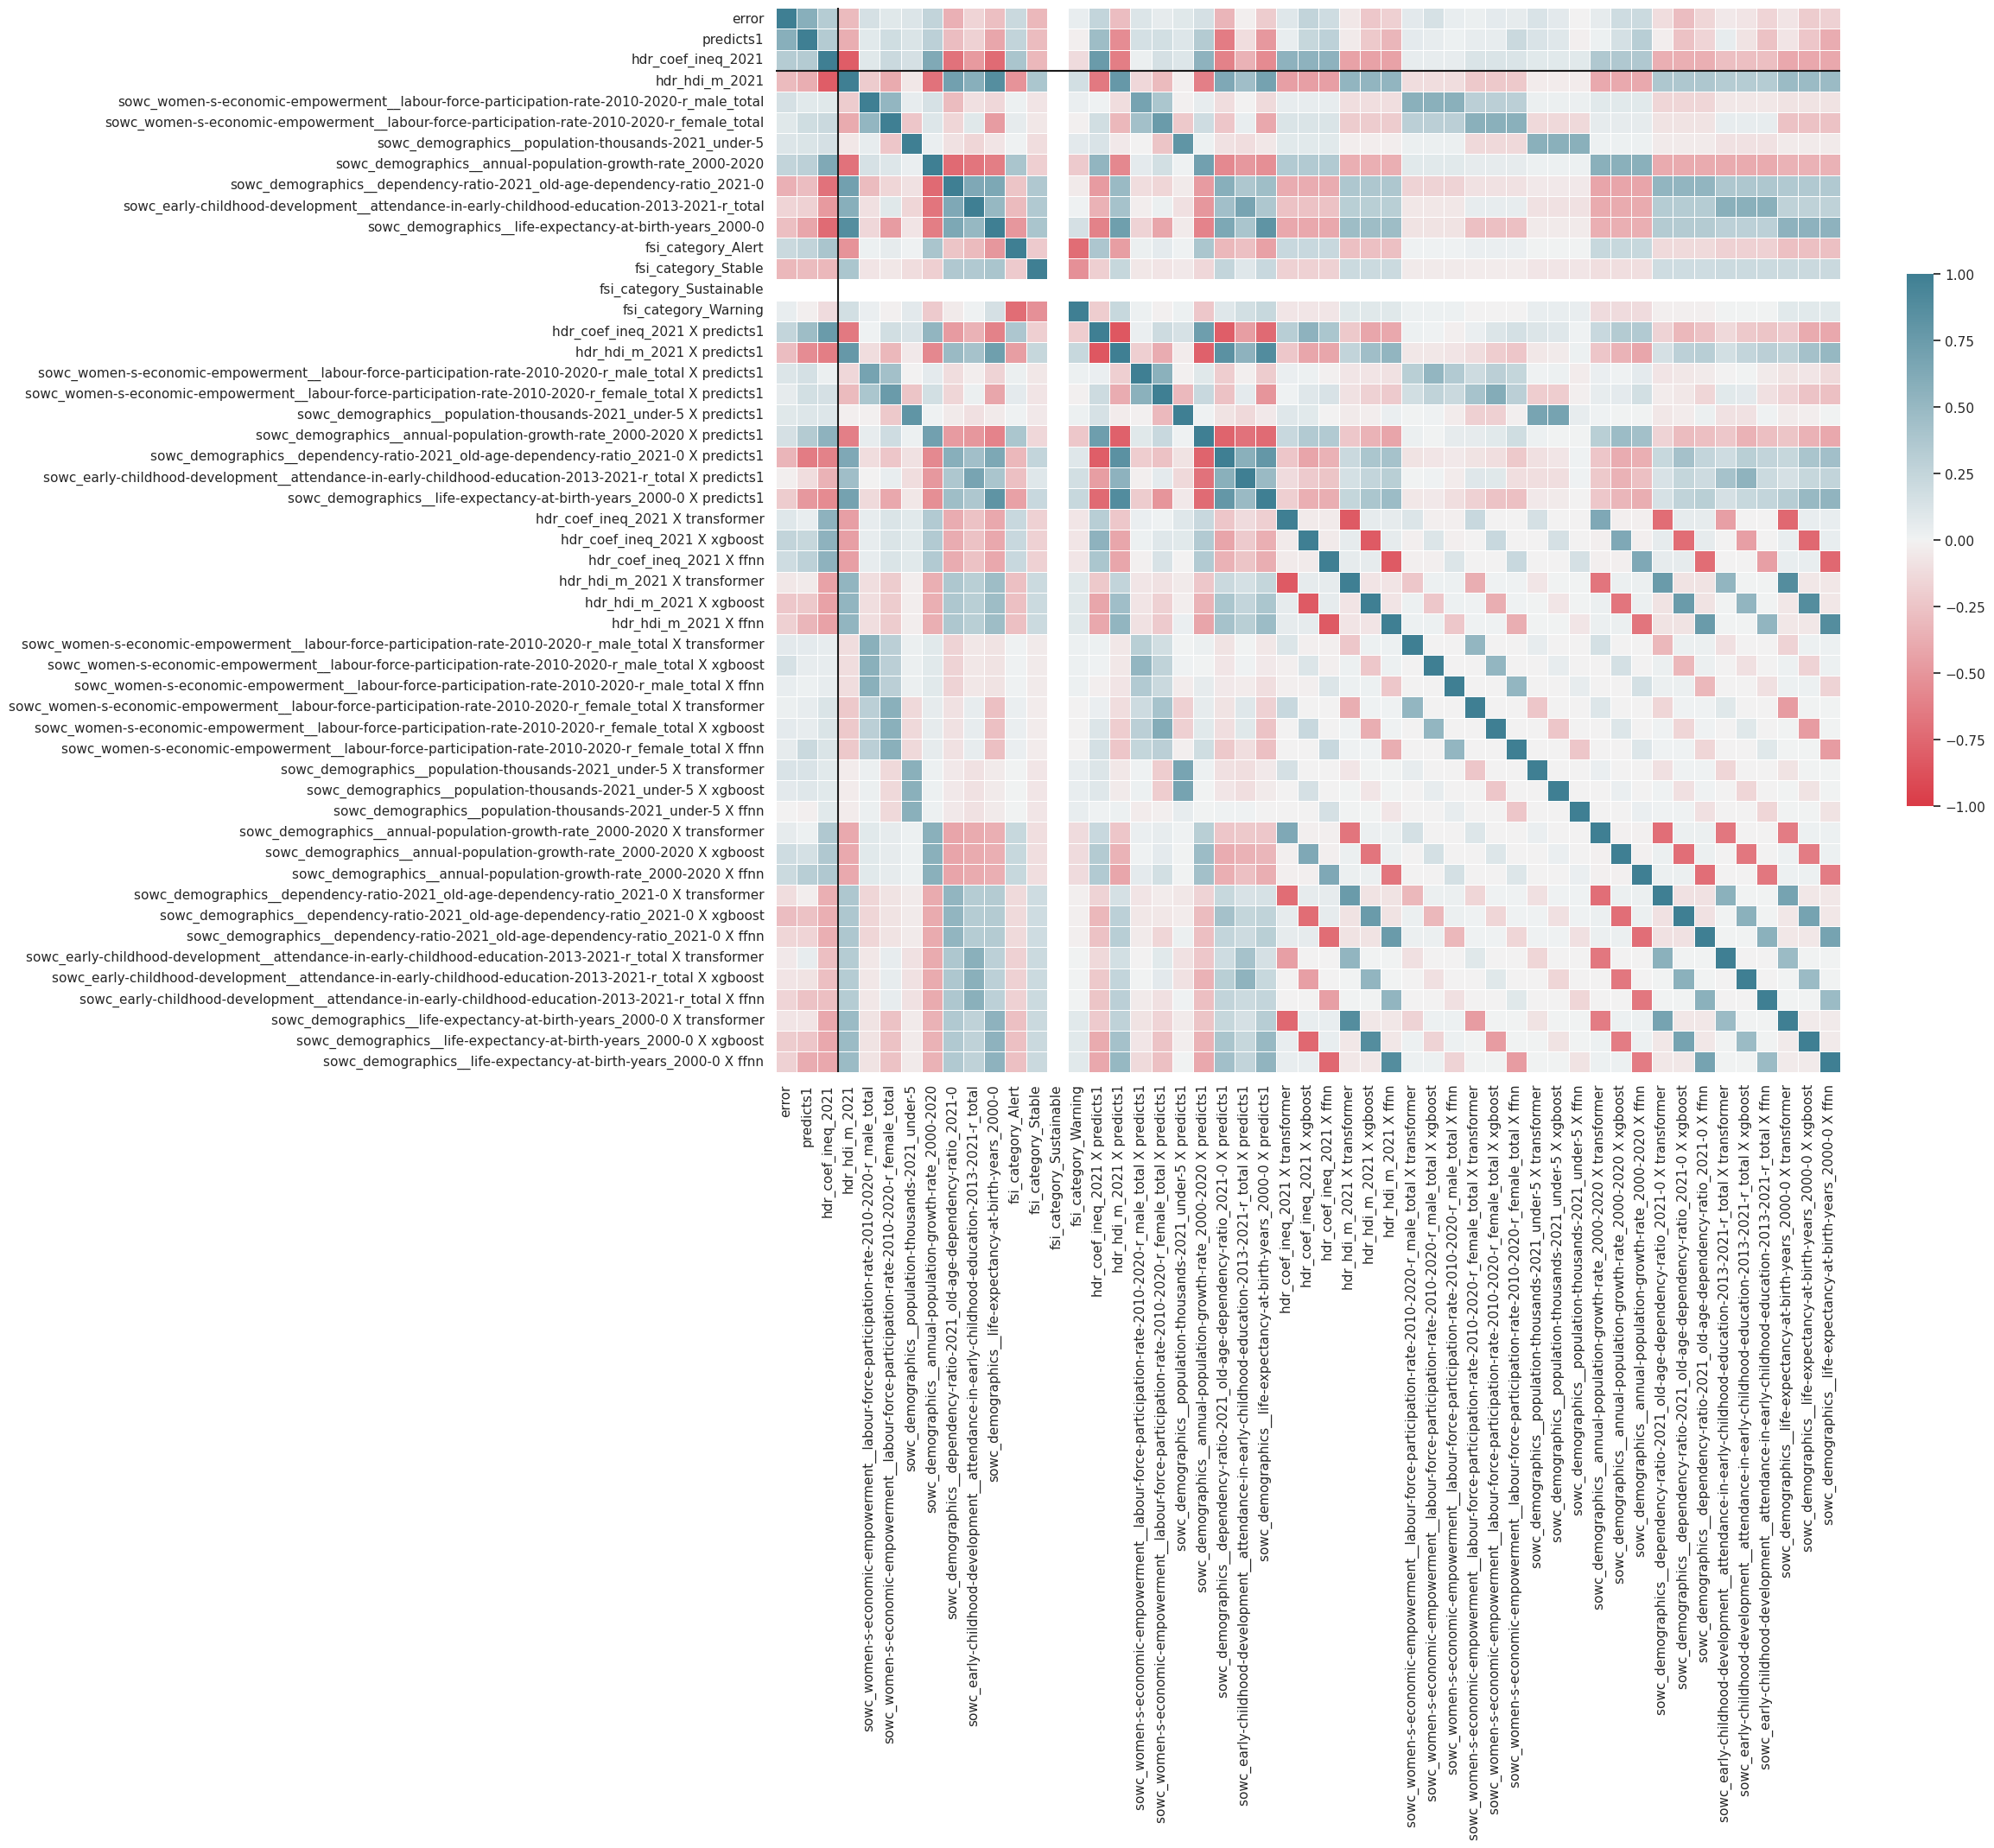

In [9]:
design_matrix.iloc[:, 1:] # This is the ERROR of the prediction. We won't fix it since it will change.

del design_matrix['ffnn']
del design_matrix['transformer']
del design_matrix['xgboost']

corr_heatmap(design_matrix)
_ = plt.axhline(y=3, c='k'); plt.axvline(x=3, c='k')

## As this correlation matrix shows, the correlation is about the same as before (rather unsurprisingly, since the indicator variables x continuous variables only have correlation with themselves.

In [10]:
model1 = sm.OLS(design_matrix.error, sm.add_constant(design_matrix.iloc[:, 1:]))
design_matrix_model_1 = design_matrix.copy()
model1.fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  error   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     12.74
Date:                Mon, 18 Dec 2023   Prob (F-statistic):           2.37e-54
Time:                        14:51:50   Log-Likelihood:                 410.02
No. Observations:                 582   AIC:                            -740.0
Df Residuals:                     542   BIC:                            -565.4
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
=============================================================================================================================================================================
                                                                                                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                         0.2696      0.008     33.272      0.000       0.254       0.285
predicts1                                                                                                     0.2110      0.019     11.310      0.000       0.174       0.248
hdr_coef_ineq_2021                                                                                            0.0368      0.012      3.044      0.002       0.013       0.060
hdr_hdi_m_2021                                                                                                0.0177      0.019      0.932      0.352      -0.020       0.055
sowc_women-s-economic-empowerment__labour-force-participation-rate-2010-2020-r_male_total                     0.0114      0.009      1.232      0.219      -0.007       0.030
sowc_women-s-economic-empowerment__labour-force-participation-rate-2010-2020-r_female_total                  -0.0059      0.010     -0.565      0.572      -0.026       0.015
sowc_demographics__population-thousands-2021_under-5                                                          0.0105      0.012      0.871      0.384      -0.013       0.034
sowc_demographics__annual-population-growth-rate_2000-2020                                                    0.0056      0.010      0.563      0.573      -0.014       0.025
sowc_demographics__dependency-ratio-2021_old-age-dependency-ratio_2021-0                                     -0.0473      0.014     -3.373      0.001      -0.075      -0.020
sowc_early-childhood-development__attendance-in-early-childhood-education-2013-2021-r_total                   0.0198      0.009      2.269      0.024       0.003       0.037
sowc_demographics__life-expectancy-at-birth-years_2000-0                                                      0.0049      0.018      0.271      0.786      -0.030       0.040
fsi_category_Alert                                                                                            0.1302      0.013      9.868      0.000       0.104       0.156
fsi_category_Stable                                                                                           0.0437      0.014      3.113      0.002       0.016       0.071
fsi_category_Sustainable                                                                                   3.076e-17   1.71e-17      1.798      0.073   -2.85e-18    6.44e-17
fsi_category_Warning                                                                                          0.0957      0.0

## Here is the first run of our model. As we can see, this initial model is very flawed and suffers from strong multicolinearity, with a Condition Number of 1.51e+16, which is outrageously high.

## First, we created Model 2 by removing all of the variables whose sum of values added up to less than 8, as these covariates were rather infrequent and so increased the condition number by a lot.

In [11]:
model_2variables = design_matrix.iloc[:, 1:].loc[:,design_matrix.sum()>8].columns.tolist()

design_matrix_model_2 = design_matrix.copy()

for var in design_matrix.iloc[:, 1:].loc[:,design_matrix.sum()<= 8].columns.tolist():
    del design_matrix[var]

model_2 = sm.OLS(design_matrix.error, sm.add_constant(design_matrix[model_2variables]))
model_2.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  error   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     18.80
Date:                Mon, 18 Dec 2023   Prob (F-statistic):           6.42e-57
Time:                        14:51:50   Log-Likelihood:                 393.33
No. Observations:                 582   AIC:                            -736.7
Df Residuals:                     557   BIC:                            -627.5
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=============================================================================================================================================================================
                                                                                                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                         0.2753      0.007     39.651      0.000       0.262       0.289
predicts1                                                                                                     0.1861      0.014     13.668      0.000       0.159       0.213
hdr_coef_ineq_2021                                                                                            0.0424      0.009      4.677      0.000       0.025       0.060
sowc_women-s-economic-empowerment__labour-force-participation-rate-2010-2020-r_male_total                     0.0226      0.007      3.131      0.002       0.008       0.037
sowc_women-s-economic-empowerment__labour-force-participation-rate-2010-2020-r_female_total                  -0.0153      0.008     -1.982      0.048      -0.030      -0.000
sowc_demographics__population-thousands-2021_under-5                                                          0.0157      0.012      1.351      0.177      -0.007       0.039
sowc_demographics__annual-population-growth-rate_2000-2020                                                    0.0165      0.008      1.939      0.053      -0.000       0.033
sowc_early-childhood-development__attendance-in-early-childhood-education-2013-2021-r_total                   0.0204      0.008      2.568      0.010       0.005       0.036
fsi_category_Alert                                                                                            0.1192      0.011     10.458      0.000       0.097       0.142
fsi_category_Stable                                                                                           0.0506      0.013      3.935      0.000       0.025       0.076
fsi_category_Warning                                                                                          0.1055      0.007     14.339      0.000       0.091       0.120
hdr_coef_ineq_2021 X predicts1                                                                               -0.0607      0.018     -3.323      0.001      -0.097      -0.025
sowc_women-s-economic-empowerment__labour-force-participation-rate-2010-2020-r_male_total X predicts1        -0.0198      0.015     -1.349      0.178      -0.049       0.009
sowc_women-s-economic-empowerment__labour-force-participation-rate-2010-2020-r_female_total X predicts1       0.0053      0.015      0.361      0.718      -0.024       0.034
sowc_demographics__population-thousands-2021_under-5 X predicts1                                             -0.0308      0.0

## This eliminated some of the condition number number, but it is still extremely high

## Using backwards selection, we eliminated variables with the p-values higher than 0.3 one by one, and ended up with Model 3.

In [12]:
model_3variables = model_2variables.copy()
vars_to_remove = []
for i in range (1, len(model_2.fit().summary().tables[1].data)):
    covariate = model_2.fit().summary().tables[1].data[i]
    if float(covariate[4]) > 0.3:
        vars_to_remove.append(covariate[0])

for var in vars_to_remove:
    model_3variables.remove(var)
    del design_matrix[var]
    
model_3variables.remove('fsi_category_Warning')
del design_matrix['fsi_category_Warning']

In [14]:
model3 = sm.OLS(design_matrix.error, sm.add_constant(design_matrix[model_3variables]))
model3.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  error   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     26.60
Date:                Mon, 18 Dec 2023   Prob (F-statistic):           3.54e-61
Time:                        14:51:58   Log-Likelihood:                 392.00
No. Observations:                 582   AIC:                            -748.0
Df Residuals:                     564   BIC:                            -669.4
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================================================================
                                                                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                     0.3809      0.009     42.164      0.000       0.363       0.399
predicts1                                                                                                 0.1857      0.013     14.197      0.000       0.160       0.211
hdr_coef_ineq_2021                                                                                        0.0467      0.011      4.335      0.000       0.026       0.068
sowc_women-s-economic-empowerment__labour-force-participation-rate-2010-2020-r_male_total                 0.0220      0.009      2.496      0.013       0.005       0.039
sowc_women-s-economic-empowerment__labour-force-participation-rate-2010-2020-r_female_total              -0.0190      0.007     -2.906      0.004      -0.032      -0.006
sowc_demographics__population-thousands-2021_under-5                                                      0.0266      0.023      1.177      0.240      -0.018       0.071
sowc_demographics__annual-population-growth-rate_2000-2020                                                0.0141      0.010      1.410      0.159      -0.006       0.034
sowc_early-childhood-development__attendance-in-early-childhood-education-2013-2021-r_total               0.0219      0.008      2.793      0.005       0.006       0.037
fsi_category_Alert                                                                                        0.0126      0.014      0.894      0.372      -0.015       0.040
fsi_category_Stable                                                                                      -0.0557      0.018     -3.140      0.002      -0.091      -0.021
hdr_coef_ineq_2021 X predicts1                                                                           -0.0712      0.013     -5.353      0.000      -0.097      -0.045
sowc_women-s-economic-empowerment__labour-force-participation-rate-2010-2020-r_male_total X predicts1    -0.0175      0.011     -1.555      0.121      -0.040       0.005
sowc_demographics__population-thousands-2021_under-5 X predicts1                                         -0.0316      0.022     -1.457      0.146      -0.074       0.011
hdr_coef_ineq_2021 X xgboost                                                                              0.0406      0.013      3.114      0.002       0.015       0.066
sowc_women-s-economic-empowerment__labour-force-participation-rate-2010-2020-r_male_total X xgboost       0.0239      0.012      2.039      0.042       0.001       0.047
sowc_demographics__popu

## This model is looking much better, with a much lower condition number of 12.7, and maintains a reasonable $R^{2}$ of 0.445.

In [37]:
design_matrix.columns.tolist()[1:]

['predicts1',
 'hdr_coef_ineq_2021',
 'sowc_women-s-economic-empowerment__labour-force-participation-rate-2010-2020-r_male_total',
 'sowc_women-s-economic-empowerment__labour-force-participation-rate-2010-2020-r_female_total',
 'sowc_demographics__population-thousands-2021_under-5',
 'sowc_demographics__annual-population-growth-rate_2000-2020',
 'sowc_early-childhood-development__attendance-in-early-childhood-education-2013-2021-r_total',
 'fsi_category_Alert',
 'fsi_category_Stable',
 'hdr_coef_ineq_2021 X predicts1',
 'sowc_women-s-economic-empowerment__labour-force-participation-rate-2010-2020-r_male_total X predicts1',
 'sowc_demographics__population-thousands-2021_under-5 X predicts1',
 'hdr_coef_ineq_2021 X xgboost',
 'sowc_women-s-economic-empowerment__labour-force-participation-rate-2010-2020-r_male_total X xgboost',
 'sowc_demographics__population-thousands-2021_under-5 X transformer',
 'sowc_demographics__population-thousands-2021_under-5 X ffnn',
 'sowc_demographics__annual-

## These are our final covariates.

In [38]:
from sklearn import tree, model_selection

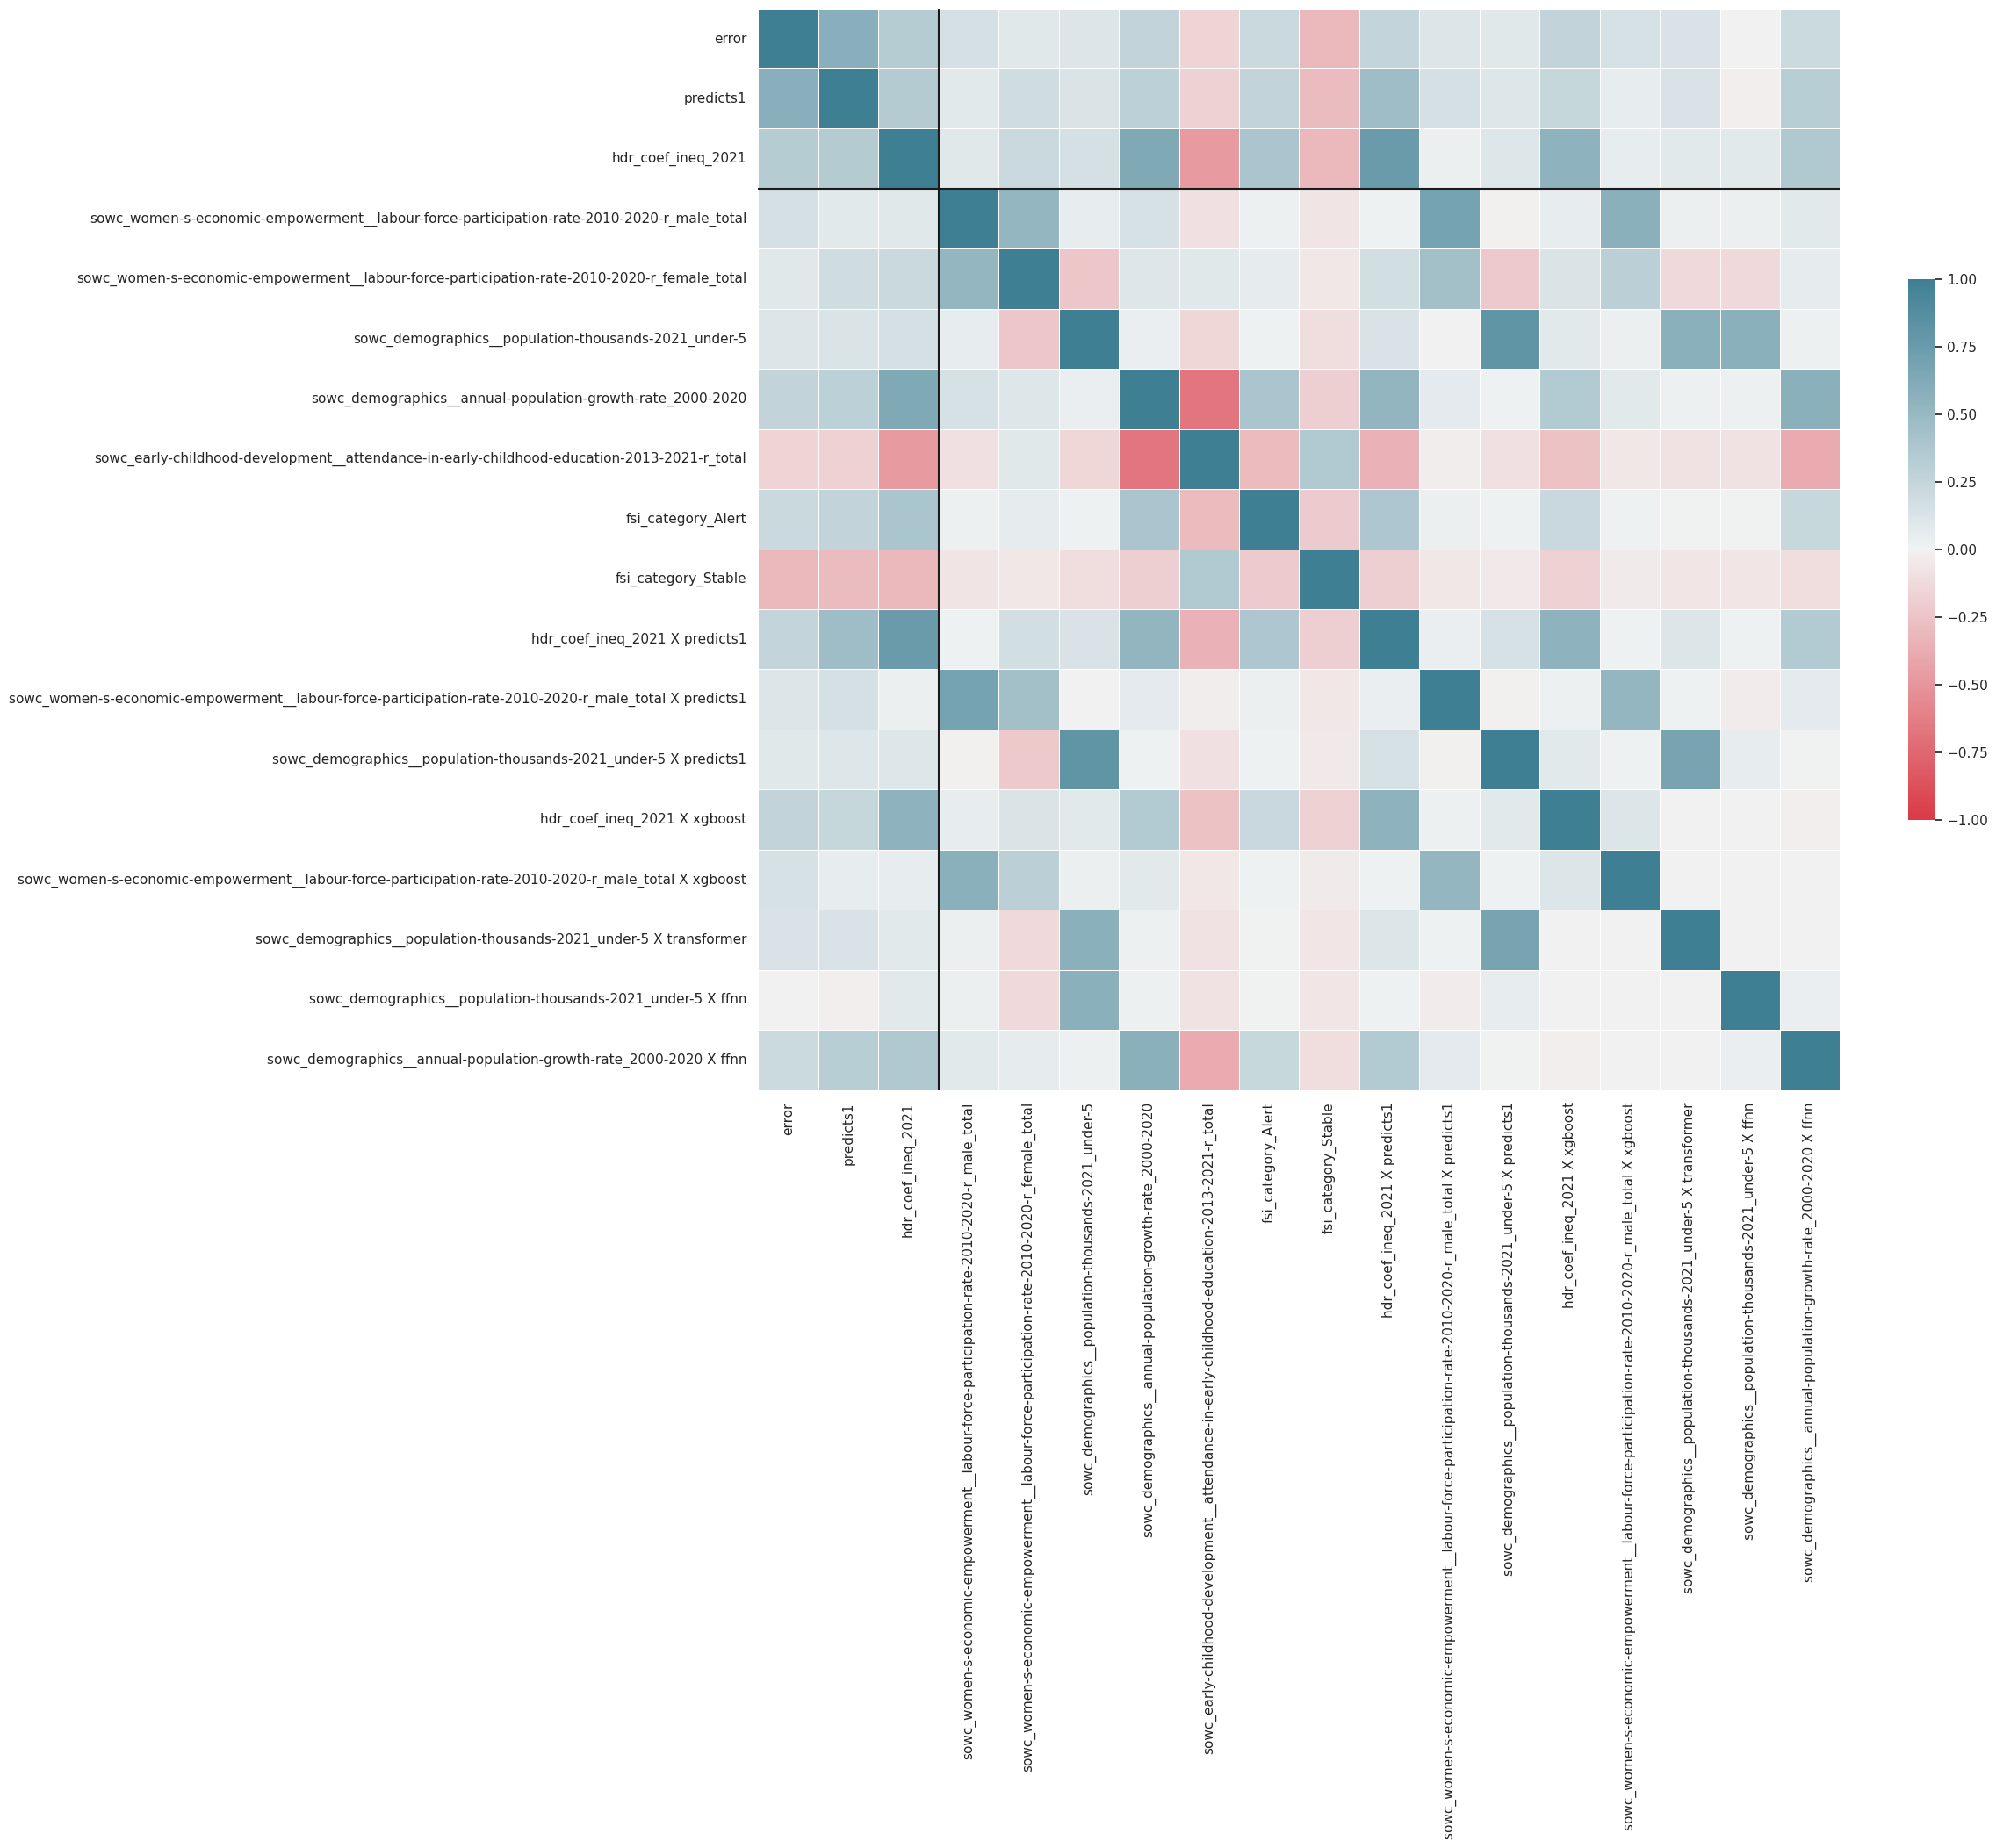

In [39]:
corr_heatmap(design_matrix[['error'] + model_3variables])
_ = plt.axhline(y=3, c='k'); plt.axvline(x=3, c='k')

## If we look at the correlation matrix of the final covariates model_3variables, we can see that the correlation isn't very strong anymore between the variables, which shows that there is very little multicolinearity between them.

## Finally, we train-tested the models to show how effective each one was.

In [40]:
np.random.seed(7)

In [41]:
from sklearn import tree, model_selection
import statistics
y = design_matrix.error

train3, test3 = model_selection.train_test_split(design_matrix, train_size=0.8)
train2, test2 = model_selection.train_test_split(design_matrix_model_2, train_size=0.8)
train1, test1 = model_selection.train_test_split(design_matrix_model_1, train_size=0.8)


model_3_train_test_fit = sm.OLS(train3.error, sm.add_constant(train3.iloc[:, 1:])).fit()
model_3_train_RMSE = ((train3.error - model_3_train_test_fit.predict())**2).mean()**.5
model_3_test_RMSE = ((test3.error - 
                      model_3_train_test_fit.predict(sm.add_constant(test3.iloc[:, 1:]))
                     )**2).mean()**.5

model_2_train_test_fit = sm.OLS(train2.error, sm.add_constant(train2.iloc[:, 1:])).fit()
model_2_train_RMSE = ((train2.error - model_2_train_test_fit.predict())**2).mean()**.5
model_2_test_RMSE = ((test2.error - 
                      model_2_train_test_fit.predict(sm.add_constant(test2.iloc[:, 1:]))
                     )**2).mean()**.5

model_1_train_test_fit = sm.OLS(train1.error, sm.add_constant(train1.iloc[:, 1:])).fit()
model_1_train_RMSE = ((train1.error - model_1_train_test_fit.predict())**2).mean()**.5
model_1_test_RMSE = ((test1.error - 
                      model_1_train_test_fit.predict(sm.add_constant(test1.iloc[:, 1:]))
                     )**2).mean()**.5


import plotly.express as px

fig = px.bar(pd.DataFrame({'RMSE': [model_1_train_RMSE, model_2_train_RMSE, model_3_train_RMSE] + 
                             [model_1_test_RMSE, model_2_test_RMSE, model_3_test_RMSE],
                     'Score': ['Training']*3+['Testing']*3,
                     'Model': [1,2,3]+[1,2,3]}), 
       y='RMSE', x='Model', color='Score', barmode='group')

fig.show()

# As we can see, Model 1 has the highest RMSE on the test data (in red) followed by Model 2, followed by Model 3 with the lowest (which actually performed better on the test data!).

In [42]:
errors =[]
for i in range (len(test3)):
    errors.append(test3.error.values[i] - model_3_train_test_fit.predict(test3).values[i])

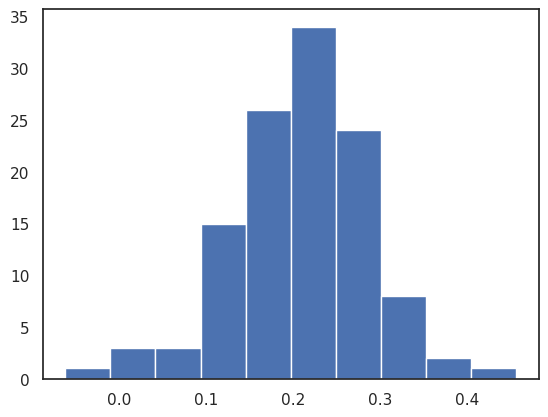

In [43]:
_ = plt.hist(y-model_3_train_test_fit.predict(test3))

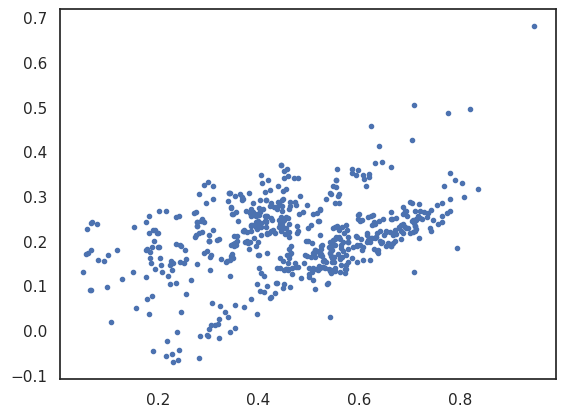

In [47]:
px.scatter(errors, trendline = 'ols')
#_ = plt.plot(model_3_train_test_fit.predict(test3)+0.05*np.random.uniform(size=len(test3)), test3.error-model_3_train_test_fit.predict(test3), '.')

_ = plt.plot(design_matrix.error, design_matrix.error-model_3_train_test_fit.predict(design_matrix), '.')

## As we can see, normality distribution of the errors seems good, and the homoskedasticity also seems fairly good.

## Final thoughts / room for improvement
Our model is of course not perfect by any means. First of all, there are certainly more variables that we could find that could make our model's predictions more accurate. Additionally, our model counts the error of a prediction as the absolute value of the true outcome minus the predicted outcome without differentiating between if the prediction is a type 1 or type 2 error. For example, a prediction of 0.6 when there actually isn't conflict is weighted the same as a prediction of 0.4 when there actually is conflict. However, in this context, a prediction of 0.4 when there actually is conflict (a type 2 error or false negative) is actually worse than a prediction of 0.6 when there actually isn't conflict (a type 1 error or false positive). This is because in the context of conflict escalation, it is better to be prepared for conflict when there isn't any than to be unprepared for conflict when there is. However, this raises an ethical question: how much accuracy are we willing to sacrifice in exchange for higher sensitivity? (the capacity of the model to correctly assess true positives).